# Model Training
Trains a model on past data.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

### SET PARAMETERS:


In [314]:
TICKER="TSLA"
DATA_INTERVAL_MINUTES = 15   # (Set to 5 or 15)
DATA_AFTER_HOURS = False

DAYS_PREDICT = 15
# ISSUE: If stock goes down slowly, less than 'DOWN_PCTS_PREDICT' then won't sell but after few periods will be very down 
#  example: DOWN_PCTS_PREDICT=5% then down 4% and down 3% and down 1%... and never sell
DOWN_PCTS_PREDICT= [5.0]
UP_PCTS_PREDICT= [7.0]

signal_avg= [
    2, 
    3, 
    5, 
    8, 
    13, 
    21, 
    34, 
    55, 
    89, 
    144, 
    233, 
    377, 
    610, 
    987, 
    1597, 
    2584]

PREDICT_UP = True
if PREDICT_UP:
    INDEX_KEEP= 2
    INDEX_REMOVE_A= 0
    INDEX_REMOVE_B= 1
else:
    INDEX_KEEP= 0
    INDEX_REMOVE_A= 1
    INDEX_REMOVE_B= 2

TRAIN_SPLIT = 0.9

# TODO: When executing only using 33-38% GPU - Try different BATCH_SIZE see if parallelism increases? Learning decreases because less batches?
BATCH_SIZE= 32

HIDDEN_UNITS=12

TRAINING_THRESHOLD = 0.7

#### DOWNLOAD DATA (DON'T EXECUTE IF ALREADY LOADED)

In [ ]:
import sys
sys.path.append('..\\..')

from datetime import datetime

import settings
import apis.tiingo_api as tiingo

secret_key= settings.get_secret("tiingo-key")

### TRAINING DATA
csv_data2017= tiingo.download_ticker(secret_key, TICKER, datetime(2017, 1, 1), datetime(2018,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2018= tiingo.download_ticker(secret_key, TICKER, datetime(2018, 1, 1), datetime(2019,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2019= tiingo.download_ticker(secret_key, TICKER, datetime(2019, 1, 1), datetime(2020,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2020= tiingo.download_ticker(secret_key, TICKER, datetime(2020, 1, 1), datetime(2021,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2021= tiingo.download_ticker(secret_key, TICKER, datetime(2021, 1, 1), datetime(2022,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2022= tiingo.download_ticker(secret_key, TICKER, datetime(2022, 1, 1), datetime(2023,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 1, 1), datetime(2024,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
# csv_data2024= tiingo.download_ticker(secret_key, TICKER, datetime(2024, 1, 1), datetime(2024,2,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)

In [ ]:
import io
import pandas as pd

# ### TRAINING DATA
df2017 = pd.read_csv(io.StringIO(csv_data2017))
df2018 = pd.read_csv(io.StringIO(csv_data2018))
df2019 = pd.read_csv(io.StringIO(csv_data2019))
df2020 = pd.read_csv(io.StringIO(csv_data2020))
df2021 = pd.read_csv(io.StringIO(csv_data2021))
df2022 = pd.read_csv(io.StringIO(csv_data2022))
df2023 = pd.read_csv(io.StringIO(csv_data2023))
# df2024 = pd.read_csv(io.StringIO(csv_data2024))

if not df2017.empty:
    print("Concatenating from 2017")
    df = pd.concat([df2017, df2018, df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
elif not df2018.empty:
    print("Concatenating from 2018")
    df = pd.concat([df2018, df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
elif not df2019.empty:
    print("Concatenating from 2019")
    df = pd.concat([df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
elif not df2020.empty:
    print("Concatenating from 2020")
    df = pd.concat([df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
else:
    print("Concatenating from 2021")
    df = pd.concat([df2021, df2022, df2023], axis=0, ignore_index=True)

# if not df2024.empty:
#     print("Concatenating from 2024")
#     df = pd.concat([df, df2024], axis=0, ignore_index=True)

In [ ]:
# Validates that data has been concatenated correctly = ordered ascending
if df["date"].is_monotonic_increasing and df["date"].is_unique:
    print("Correct: DataFrame is in ascending order.")
else:
    print("Error: DataFrame is not in ascending order.")


In [ ]:
# Displays first and last element in the data
print(f"Data first:\n{df[['date', 'close']][:5]}")
print(f"Data last:\n{df[['date', 'close']][-5:]}")

In [315]:

# If quotes every 15min there 26 per day if quotes every 5min there are 78 per day
TICKS_IN_DAY = 26 if DATA_INTERVAL_MINUTES == 15 else 78
# How many data ticks are inspecting to determine the if up or down by percentage 
TICKS_PREDICT= TICKS_IN_DAY * DAYS_PREDICT
REACH_PCT= 0.95

import classifiers.up_down_classifier as udc
import classifiers.ewa_classifier as ec

alpha= ec.calculate_ewa_alpha(TICKS_PREDICT, REACH_PCT)
print(f"alpha: {alpha:.4f} for window: {TICKS_PREDICT} and reach: {REACH_PCT}")

classes_calc = udc.UpsDownsClassifier(TICKS_PREDICT, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

close_prices = df['close'].astype(float).tolist()
input_data= ec.calculate_ewas(close_prices, alpha)

classes= classes_calc.classify(input_data)
print(f"Check correct 'nan' point (window={TICKS_PREDICT}): {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]}")
print(f"prices vs input_data: {[(p, c) for p, c in zip(close_prices[2650:3000], input_data[2650:3000])]}")
print(f"input_data vs classes: {[(p, c) for p, c in zip(input_data[2650:3000], classes[2650:3000])]}")


alpha: 0.0077 for window: 390 and reach: 0.95
Check correct 'nan' point (window=390): [1, nan]
prices vs input_data: [(309.53, 311.3514908170164), (310.155, 311.3423353428517), (308.87, 311.3234171848216), (309.4, 311.3086993147861), (309.91, 311.29799655362945), (309.975, 311.2878730653465), (313.1, 311.30173934923044), (313.23, 311.3164942811696), (312.45, 311.3251677972356), (312.89, 311.3371417970363), (312.15, 311.34336173802615), (312.31, 311.35075839457227), (312.07, 311.3562619871139), (312.43, 311.3644781643689), (313.37, 311.37982429414416), (313.19, 311.39367564734533), (313.45, 311.4094105148572), (313.0, 311.42158160779894), (313.82, 311.43993415786747), (314.47, 311.46312003538566), (314.87, 311.48918927140033), (315.34, 311.5186554383256), (315.9, 311.55218121752125), (315.29, 311.5807827770222), (315.49, 311.6106958668513), (314.79, 311.63502370659626), (315.81, 311.66697036849183), (316.84, 311.70655407316457), (318.06, 311.7551702507503), (318.2, 311.80448569172637), 

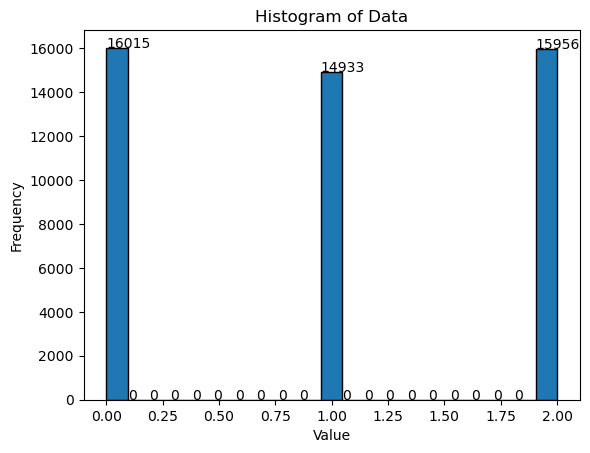

In [316]:
import matplotlib.pyplot as plt

# Create a histogram
hist_values, bin_edges, _ = plt.hist(classes, bins=21, edgecolor='black')

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display frequency on top of each bar
for value, edge in zip(hist_values, bin_edges[:-1]):
    plt.text(edge, value, str(int(value)), color='black')
    
# Show the histogram
plt.show()


In [317]:
# Show percentages of each class value
import utils.list_utils as lu

lu.display_frequency_classes(classes, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

Total: 47294
 33.86%  16015 times -5.0% change (0)
 31.57%  14933 times   0% change (1)
 33.74%  15956 times 7.0% change (2)
  0.82%    390 times   0% change (nan)


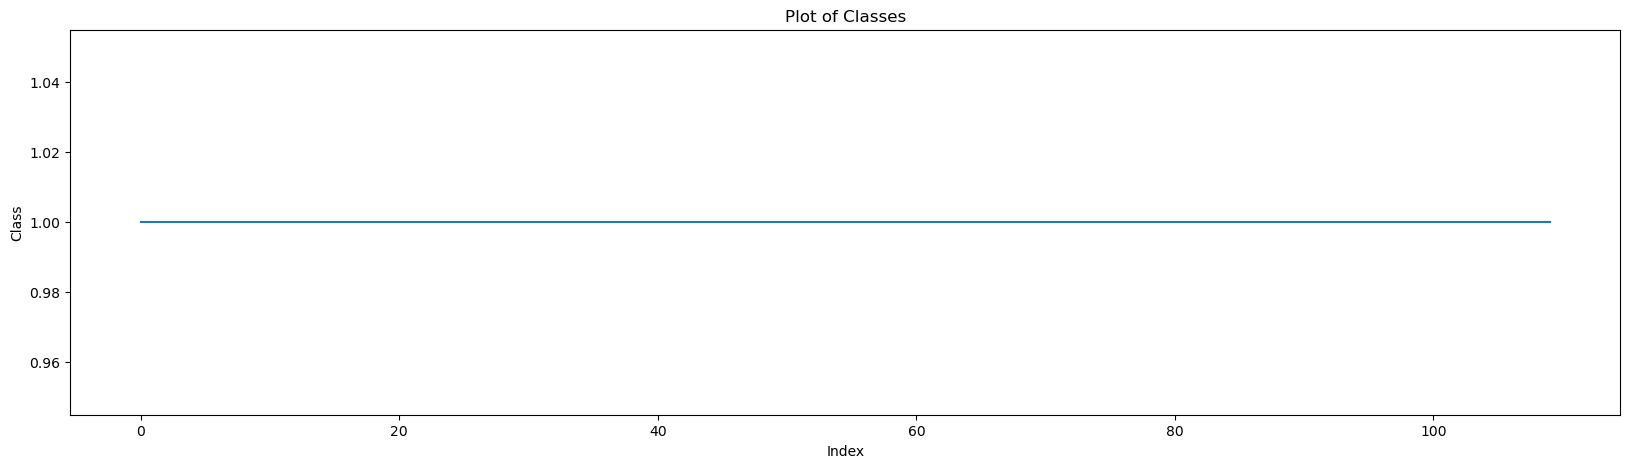

In [318]:
# Display classes value changes over time (last 500 ticks)
graph_ticks = 500
x = range(len(classes[-graph_ticks:]))

plt.figure(figsize=(20,5))
plt.plot(x, classes[-graph_ticks:], linestyle='-')


plt.xlabel('Index')
plt.ylabel('Class')
plt.title('Plot of Classes')

plt.show()

In [319]:

# Calculate the signals as input for the neural network as proportions
import preprocessing.proportions_calc as proportions

signals_calculator = proportions.ProportionsCalc(signal_avg)

proportions_avg = signals_calculator.calculate(close_prices)


In [320]:
print(f"Prices length: {len(close_prices)}")
print(f"Proportions length: {len(proportions_avg[-1])}")

print(f"Last 10 close: {close_prices[-10:]}")
print(f"Last 10 proportions(avg={signal_avg[0]}): {proportions_avg[0][-10:]}")

print(f"Proportions avgs: Count: {len(signal_avg)} Max: {signal_avg[-1]}")
# At the end of the data, when less ticks than necessary no possible to predict so "nan" 
print(f"Classes last non-nan: {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]} len: {len(classes)}")
print(f"Proportions first non-nan(avg={signal_avg[-1]}): {proportions_avg[-1][signal_avg[-1]-2:signal_avg[-1]]} len: {len(proportions_avg[-1])}")
print(f"Proportions (avg={signal_avg[0]}) Min: {min(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT])}")
print(f"Proportions (avg={signal_avg[-1]}) Min: {min(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT])}")

Prices length: 47294
Proportions length: 47294
Last 10 close: [250.6, 250.715, 249.965, 249.415, 250.09, 250.605, 250.4, 250.4, 249.19, 248.5]
Last 10 proportions(avg=2): [0.001486432561795425, 0.00022934407588670722, -0.0015002100294603995, -0.0011025800373436819, 0.001349514174840805, 0.001027513417473412, -0.000409345047979476, -5.618508853055105e-14, -0.002427866286825549, -0.0013883299799358857]
Proportions avgs: Count: 16 Max: 2584
Classes last non-nan: [1, nan] len: 47294
Proportions first non-nan(avg=2584): [nan, 0.11402957095848261] len: 47294
Proportions (avg=2) Min: -1.9502283711002686 Max: 0.07537671689559655
Proportions (avg=2584) Min: -2.487705376731546 Max: 0.6134148294687675


In [321]:
# Removing the "nan" from the proportions
#   At the beging first signal_avg[-1] are "nan" (need previous values for first avg.)
#   At the end decided not predict if period to predict is shorter
targets = classes[signal_avg[-1]-1:-TICKS_PREDICT]
inputs = []
for proportion in proportions_avg:
    proportion_cut= proportion[signal_avg[-1]-1:-TICKS_PREDICT]
    print(proportion_cut[:2])
    inputs.append(proportion_cut)

print(f"First target: {targets[0]} and last target: {targets[-1]}")
print(f"Classes: {len(classes)} after cut to targets: {len(targets)}")
print(f"Inputs len: {len(inputs[len(signal_avg)-1])}")
print(f"Distinct targets: {list(set(targets))}")


[-0.0003727231477269334, -0.0001458907440417405]
[-0.0009615176854427643, -0.0004430755930184548]
[0.0001750178258897727, -0.0001685848597828527]
[-0.00013369417255900415, -6.0787810022290846e-05]
[-0.0028833064906182465, -0.002512562814070278]
[-0.006446644256978007, -0.005943696979522491]
[-0.010900960500879488, -0.010669571767757994]
[-0.01059741775046441, -0.010780294434050569]
[-0.007264368686739381, -0.007245542682604316]
[-0.015404652197086699, -0.015328997136219462]
[-0.027568646019697888, -0.027699831011624574]
[-0.01854184824257448, -0.018706994371188678]
[-0.012875100818555793, -0.013213236994065606]
[0.005063869455054647, 0.004668290302711154]
[0.06954253289545267, 0.06916454533154584]
[0.11402957095848261, 0.11365373883298692]
First target: 2 and last target: 1
Classes: 47294 after cut to targets: 44321
Inputs len: 44321
Distinct targets: [0, 1, 2]


In [322]:
from collections import Counter

print("Train data: 'nan' removed from begining and end")
lu.display_frequency_classes(targets, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

targets_frequency = Counter(targets)
print("VALIDATE removing should be POSITIVE?")
count_remove_a= targets_frequency[INDEX_REMOVE_A] - targets_frequency[INDEX_KEEP] + targets_frequency[INDEX_KEEP] //2
count_remove_b= targets_frequency[INDEX_REMOVE_B] - targets_frequency[INDEX_KEEP] + targets_frequency[INDEX_KEEP] //2
print(f"Removing {INDEX_REMOVE_A}: {count_remove_a}")
print(f"Removing {INDEX_REMOVE_B}: {count_remove_b}")


Train data: 'nan' removed from begining and end
Total: 44321
 35.61%  15784 times -5.0% change (0)
 31.31%  13875 times   0% change (1)
 33.08%  14662 times 7.0% change (2)
VALIDATE removing should be POSITIVE?
Removing 0: 8453
Removing 1: 6544


In [323]:
###################
##### SET PARAMETERS
###################
# DECISION SET: REMOVING?
indexes_remove_a= []
# 2024-03-01 Do not remove anything
# if count_remove_a > 0:
#     indexes_remove_a = get_indexes_value(targets, index_remove_a, count_remove_a)

# DECISION SET: REMOVING?
indexes_remove_b= []
# 2024-03-01 Do not remove anything
# if count_remove_b > 0:
#     indexes_remove_b = get_indexes_value(targets, index_remove_b, count_remove_b)

indexes_remove= indexes_remove_a + indexes_remove_b
targets_clean= lu.remove_indexes(targets, indexes_remove)

lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)
print(f"Targets len: {len(targets)} Targets clean: {len(targets_clean)} Difference: {len(targets)-len(targets_clean)}")

inputs_clean = [lu.remove_indexes(input, indexes_remove) for input in inputs]    
print(f"targets_clean positions(Keep={INDEX_KEEP})(First:{targets_clean.index(INDEX_KEEP)},Last:-{targets_clean[::-1].index(INDEX_KEEP)})")


Total: 44321
 35.61%  15784 times -5.0% change (0)
 31.31%  13875 times   0% change (1)
 33.08%  14662 times 7.0% change (2)
Targets len: 44321 Targets clean: 44321 Difference: 0
targets_clean positions(Keep=2)(First:0,Last:-448)


In [324]:
# Sets 'index_keep' as target = 1 and rest of indexes to target=0
targets_binary= lu.convert_binary(targets_clean, INDEX_KEEP)
print(f"targets_binary First {targets_binary.index(True)} and Last(counting from end) {targets_binary[::-1].index(True)} position with True")
print(f"targets_binary len: {len(targets_binary)} Input clean[0]: {len(inputs_clean[0])} Input clean[-1]: {len(inputs_clean[-1])}")

targets_binary First 0 and Last(counting from end) 448 position with True
targets_binary len: 44321 Input clean[0]: 44321 Input clean[-1]: 44321


In [325]:
import torch

inputs_tensor = torch.Tensor(inputs_clean)
print(f"inputs_tensor: {inputs_tensor.size()}")
inputs_tensor = inputs_tensor.T
print(f"inputs_tensor: {inputs_tensor.size()}")
targets_tensor = torch.Tensor(targets_binary)
print(f"inputs_clean len0 x len1: {len(inputs_clean)} x {len(inputs_clean[0])} -> inputs_tensor.shape: {inputs_tensor.shape}")
print(f"targets_binary.shape: {len(targets_binary)} -> targets_tensor.shape: {targets_tensor.shape}")
print(f"inputs_tensor: {inputs_tensor}")
print(f"targets_tensor: {targets_tensor}")

inputs_tensor: torch.Size([16, 44321])
inputs_tensor: torch.Size([44321, 16])
inputs_clean len0 x len1: 16 x 44321 -> inputs_tensor.shape: torch.Size([44321, 16])
targets_binary.shape: 44321 -> targets_tensor.shape: torch.Size([44321])
inputs_tensor: tensor([[-0.0004, -0.0010,  0.0002,  ...,  0.0051,  0.0695,  0.1140],
        [-0.0001, -0.0004, -0.0002,  ...,  0.0047,  0.0692,  0.1137],
        [-0.0003, -0.0004, -0.0012,  ...,  0.0040,  0.0686,  0.1131],
        ...,
        [ 0.0002,  0.0002, -0.0006,  ...,  0.0696,  0.0232,  0.0055],
        [-0.0007, -0.0009, -0.0016,  ...,  0.0683,  0.0219,  0.0041],
        [ 0.0007,  0.0004,  0.0003,  ...,  0.0696,  0.0233,  0.0055]])
targets_tensor: tensor([1., 1., 1.,  ..., 0., 0., 0.])


In [326]:
#Shuffle tensors
torch.manual_seed(42) 
permutation = torch.randperm(inputs_tensor.size(0))
inputs_tensor_shuffle = inputs_tensor[permutation]

targets_tensor_shuffle = targets_tensor[permutation]

print(f"inputs_tensor.size(0): {inputs_tensor.size(0)}")
print(f"inputs_tensor.shape: {inputs_tensor.shape} -> inputs_tensor_shuffle.shape: {inputs_tensor_shuffle.shape}")
print(f"targets_tensor.shape: {targets_tensor.shape} -> targets_tensor_shuffle.shape: {targets_tensor_shuffle.shape}")

inputs_tensor.size(0): 44321
inputs_tensor.shape: torch.Size([44321, 16]) -> inputs_tensor_shuffle.shape: torch.Size([44321, 16])
targets_tensor.shape: torch.Size([44321]) -> targets_tensor_shuffle.shape: torch.Size([44321])


In [327]:

train_test_split= int(TRAIN_SPLIT * len(targets_tensor))
inputs_tensor_train, targets_tensor_train= inputs_tensor_shuffle[:train_test_split], targets_tensor_shuffle[:train_test_split]
inputs_tensor_test, targets_tensor_test= inputs_tensor_shuffle[train_test_split:], targets_tensor_shuffle[train_test_split:]


In [328]:
print("Training dataset frequencies:")
lu.display_frequency_values(targets_tensor_train.tolist())
print("Validation dataset frequencies:")
lu.display_frequency_values(targets_tensor_test.tolist())


Training dataset frequencies:
Total: 39888
 66.88%  26676 times (0.0)
 33.12%  13212 times (1.0)
Validation dataset frequencies:
Total: 4433
 67.29%   2983 times (0.0)
 32.71%   1450 times (1.0)


In [329]:
from typing import Tuple
import torch
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(
        self,
        inputs,
        targets):
        
        self.inputs= inputs
        self.targets= targets

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        return self.inputs[index], self.targets[index]


In [330]:
from torch.utils.data import DataLoader


train_dataset= StockDataset(
  inputs_tensor_train,
  targets_tensor_train
)

print(f"train_dataset: {train_dataset[0]}")

train_dataloader= DataLoader(
  dataset=train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

train_input0, train_target0= next(iter(train_dataloader))
print(f"train_input0: {train_input0} train_target0: {train_target0}")


train_dataset: (tensor([ 0.0002,  0.0003,  0.0002, -0.0003, -0.0012, -0.0018, -0.0039, -0.0027,
         0.0003, -0.0060, -0.0150, -0.0450, -0.0445, -0.0518, -0.0767, -0.1343]), tensor(1.))
train_input0: tensor([[ 2.2565e-04,  3.1892e-04,  2.0579e-04, -3.0011e-04, -1.2484e-03,
         -1.8275e-03, -3.8636e-03, -2.6572e-03,  2.6855e-04, -5.9798e-03,
         -1.5003e-02, -4.4968e-02, -4.4510e-02, -5.1774e-02, -7.6663e-02,
         -1.3426e-01],
        [-1.0373e-03, -1.5457e-03,  2.8474e-04,  3.6381e-03,  6.2256e-03,
          9.6730e-03,  1.5613e-02,  1.4329e-02,  1.6881e-03, -5.5279e-03,
         -4.3219e-03,  7.8376e-03,  5.6513e-02,  1.0444e-01,  1.8568e-01,
          2.4162e-01],
        [ 6.9929e-16,  5.2447e-16,  1.7482e-16, -4.5454e-15, -5.2447e-16,
          1.0435e-03,  4.0705e-03,  1.4180e-02,  2.7208e-02,  3.7461e-02,
          3.8900e-02,  2.8943e-02,  3.4360e-02,  4.5564e-02,  1.0107e-01,
          1.4545e-01],
        [ 1.0379e-14,  9.8599e-15,  7.3035e-05, -5.4168e-03, 

In [331]:
test_dataset= StockDataset(
  inputs_tensor_test,
  targets_tensor_test
)

print(f"train_dataset: {train_dataset[0]}")

val_dataloader= DataLoader(
  dataset=test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

test_input0, test_target0= next(iter(val_dataloader))
print(f"test_input0: {train_input0} test_target0: {test_target0}")


train_dataset: (tensor([ 0.0002,  0.0003,  0.0002, -0.0003, -0.0012, -0.0018, -0.0039, -0.0027,
         0.0003, -0.0060, -0.0150, -0.0450, -0.0445, -0.0518, -0.0767, -0.1343]), tensor(1.))
test_input0: tensor([[ 2.2565e-04,  3.1892e-04,  2.0579e-04, -3.0011e-04, -1.2484e-03,
         -1.8275e-03, -3.8636e-03, -2.6572e-03,  2.6855e-04, -5.9798e-03,
         -1.5003e-02, -4.4968e-02, -4.4510e-02, -5.1774e-02, -7.6663e-02,
         -1.3426e-01],
        [-1.0373e-03, -1.5457e-03,  2.8474e-04,  3.6381e-03,  6.2256e-03,
          9.6730e-03,  1.5613e-02,  1.4329e-02,  1.6881e-03, -5.5279e-03,
         -4.3219e-03,  7.8376e-03,  5.6513e-02,  1.0444e-01,  1.8568e-01,
          2.4162e-01],
        [ 6.9929e-16,  5.2447e-16,  1.7482e-16, -4.5454e-15, -5.2447e-16,
          1.0435e-03,  4.0705e-03,  1.4180e-02,  2.7208e-02,  3.7461e-02,
          3.8900e-02,  2.8943e-02,  3.4360e-02,  4.5564e-02,  1.0107e-01,
          1.4545e-01],
        [ 1.0379e-14,  9.8599e-15,  7.3035e-05, -5.4168e-03, -

In [332]:
# EXECUTE FROM THIS STEP To CREATE A NETWORK WITH RANDOM WEIGHTS

import torch
from torch import nn

class StockModelBinaryV0(nn.Module):
  def __init__(self, input_features, hidden_units):
    """Initializes multi-class classification model"""
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units*16),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*16, out_features=hidden_units*8),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*8, out_features=hidden_units*4),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*4, out_features=hidden_units),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units, out_features=1)
    )

  def forward(self, x):
    # print("forward x: ",", ".join([str(num) for num in x.tolist()]))
    # Layers are defined inside the Sequencial NN and will be applied here.
    return self.linear_layer_stack(x)

# Create an instance of the model
model_0 = StockModelBinaryV0(
  input_features=len(signal_avg),
  hidden_units=HIDDEN_UNITS).to(device)


In [333]:
import torchmetrics

# loss_fn = nn.BCEWithLogitsLoss()

# Loss function for an imbalanced dataset (there many more 0's than 1's). Apply more weight to the less frequent class
num_ones = torch.count_nonzero(targets_tensor_train)
num_samples = [len(targets_tensor_train)-num_ones, num_ones]
class_weights = 1.0 / torch.tensor(num_samples, dtype=torch.float32)
class_weights = class_weights / torch.sum(class_weights)
print(f"Train positive cases: {num_ones} class_weights: {class_weights}")

loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])


Train positive cases: 13212 class_weights: tensor([0.3312, 0.6688])


In [334]:
###################
##### SET PARAMETERS
###################
# PERFORMANCE_MEASURE="accu"
# performance_fn= torchmetrics.Accuracy(task='binary').to(device)
PERFORMANCE_MEASURE="prec"
performance_fn= torchmetrics.Precision(task='binary').to(device)
# PERFORMANCE_MEASURE="reca"
# performance_fn= torchmetrics.Recall(task='binary').to(device)
###################
##### SET PARAMETERS
###################

In [335]:
# Should you reset BEST PERFORMANCE
best_val_performance = 0
model_best = None

In [336]:
###################
##### SET PARAMETERS
###################
# DO: AFTER THIS CELL RUNS EXECUTE CELLS UNTIL SAVE STEP TO KEEP BEST RESULT IN CASE IT GOES DOWN
#    lr = 0.1 -> 0.03 -> 0.001
#    epochs 200 + 200 (lr=0.1) -> 100 (lr=0.03) -> 100 (lr=0.001)
# EXECUTE 0.1 x 200 for 2 TIMES (or 400 for 1 time)
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
# epochs=400
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.03)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.005)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0007)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0001)
# epochs=100
###Using Adam optimizer
# learning_rate = 0.005
# beta_1 = 0.9
# beta_2 = 0.999
# decay = 0.01
# optimizer = optim.Adam(params=model_0.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=1e-8, weight_decay=decay)
# epochs=2000

EPOCHS=1000
LEARNING_RATE= 0.1
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)

##### Using a StepLR Scheduler
# from torch.optim.lr_scheduler import StepLR
# gamma = 0.95
# scheduler = StepLR(optimizer, step_size=20, gamma=gamma)
## If continue optimization
# learning_rate_last= 0.0080995 * 0.95
# gamma = 0.95
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=learning_rate_last*gamma)
# scheduler = StepLR(optimizer, step_size=20, gamma=gamma)
# epochs= 200

##### Using a ReduceLROnPlateau
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
###################
##### SET PARAMETERS
###################

In [337]:
from copy import deepcopy

EARLY_STOPPING_PATIENCE = 50

best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(EPOCHS):
    train_loss, train_performance= 0, 0
    train_samples = 0

    # Training
    model_0.train()

    for batch, (X, y) in enumerate(train_dataloader):
        X= X.to(device)
        y= y.to(device)

        # Forward pass
        y_logits= model_0(X).view(-1)
        
        # turn logits -> prediction probabilities -> prediction labels
        y_sigmoid_output = torch.sigmoid(y_logits)
        y_pred = (y_sigmoid_output > TRAINING_THRESHOLD).float()
        
        # Calculate loss and accuracy
        loss= loss_fn(y_logits, y)
        train_loss+= loss * X.size(0)
        train_performance+= performance_fn(y_pred, y) * X.size(0)
        train_samples += X.size(0)
        
        # Zero the gradients to avoid accomulating gradients from previous iteration
        optimizer.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Updates the model usign the gradients
        optimizer.step()
    
    train_loss /= train_samples
    train_performance /= train_samples
      
    model_0.eval()
    val_loss, val_performance= 0, 0
    val_samples = 0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X= X.to(device)
            y= y.to(device)
        
            # Predict for test data
            val_logits= model_0(X).view(-1)
            sigmoid_output = torch.sigmoid(val_logits)
            val_pred = (sigmoid_output > TRAINING_THRESHOLD).float()
            
            # Calculate test loss/accuracy
            val_loss+= loss_fn(val_logits, y) * X.size(0)
            val_performance+= performance_fn(val_pred, y) * X.size(0)
            val_samples += X.size(0)

        val_loss /= val_samples
        val_performance /= val_samples
    
    # Update the learning rate
    scheduler.step(val_loss)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch+1} lr: {optimizer.param_groups[0]['lr']:.7f} | Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.4f}% | Val loss: {val_loss:.5f} Val {PERFORMANCE_MEASURE}: {val_performance*100:.4f}%")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        model_best = deepcopy(model_0)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break    

print(f"Finished: Epoch: {epoch+1} lr: {optimizer.param_groups[0]['lr']:.7f} | Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.4f}% | Val loss: {val_loss:.5f} Val {PERFORMANCE_MEASURE}: {val_performance*100:.4f}%")

Epoch: 1 lr: 0.1000000 | Loss: 0.50129 prec: 0.0000% | Val loss: 0.49628 Val prec: 0.0000%
Epoch: 11 lr: 0.1000000 | Loss: 0.31796 prec: 91.1222% | Val loss: 0.33173 Val prec: 84.9215%
Epoch: 21 lr: 0.1000000 | Loss: 0.26959 prec: 94.3211% | Val loss: 0.30956 Val prec: 86.7785%
Epoch: 31 lr: 0.1000000 | Loss: 0.20041 prec: 95.5864% | Val loss: 0.20151 Val prec: 91.0158%
Epoch: 41 lr: 0.1000000 | Loss: 0.13614 prec: 96.8443% | Val loss: 0.14007 Val prec: 96.0154%
Epoch: 51 lr: 0.1000000 | Loss: 0.12082 prec: 97.5455% | Val loss: 0.09962 Val prec: 98.4240%
Epoch: 61 lr: 0.1000000 | Loss: 0.07560 prec: 98.0763% | Val loss: 0.06687 Val prec: 98.6022%
Epoch: 71 lr: 0.1000000 | Loss: 0.05767 prec: 98.6049% | Val loss: 0.05283 Val prec: 98.6176%
Epoch: 81 lr: 0.1000000 | Loss: 0.04875 prec: 98.6414% | Val loss: 0.05260 Val prec: 98.7343%
Epoch: 91 lr: 0.1000000 | Loss: 0.03826 prec: 99.0400% | Val loss: 0.04466 Val prec: 98.4238%
Epoch: 101 lr: 0.1000000 | Loss: 0.03320 prec: 99.1883% | Val l

Validation loss: 0.00798 Performance prec: 100.0000000%
Train validation confusion matrix:
tensor([[2983,    0],
        [  26, 1424]])
Train validation accuracy: 99.41%
Train validation precision: 100.00%
Train validation false_positives: 0 true_positives: 1424


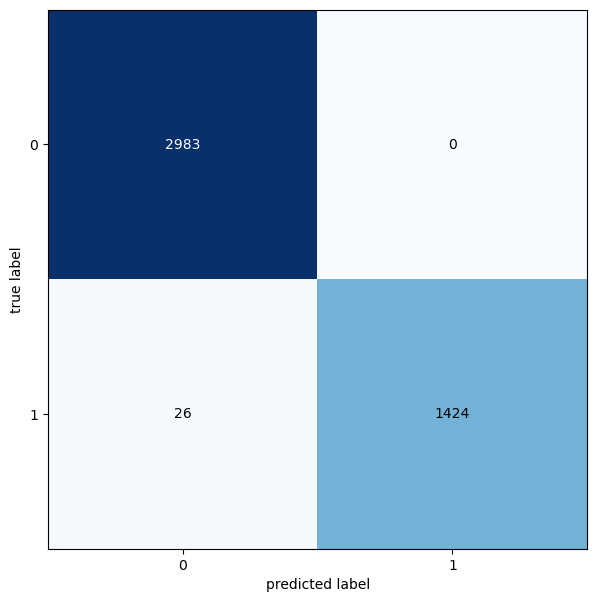

In [343]:
from torchmetrics import ConfusionMatrix, Accuracy, Precision
from mlxtend.plotting import plot_confusion_matrix

model_best.eval()
val_loss, val_performance= 0, 0
with torch.inference_mode():
    X= inputs_tensor_test.to(device)
    y= targets_tensor_test.to(device)

    # Predict for validation data
    val_logits= model_best(X).view(-1)
    sigmoid_output = torch.sigmoid(val_logits)
    val_pred = (sigmoid_output > TRAINING_THRESHOLD).float()
    
    # Calculate loss/performance(accuracy|precision)
    val_loss+= loss_fn(val_logits, y)
    val_performance+= performance_fn(val_pred, y)

print(f"Validation loss: {val_loss:.5f} Performance {PERFORMANCE_MEASURE}: {val_performance*100:.7f}%")

confmat= ConfusionMatrix(task='binary')

# test_data.targets are the values we want to predict in the test dataloader
confmat_tensor= confmat(
  preds= val_pred.cpu(),
  target= targets_tensor_test.cpu())

# Plot confusion matrix
fig, ax= plot_confusion_matrix(
  conf_mat= confmat_tensor.numpy(),
  figsize= (10, 7)
)

accuracy_fn= Accuracy(task='binary').to(device)
val_accuracy = accuracy_fn(val_pred, y)
print(f"Train validation confusion matrix:\n{confmat_tensor}")

precision_fn= Precision(task='binary').to(device)
val_precision = precision_fn(val_pred, y)
print(f"Train validation accuracy: {val_accuracy*100:.2f}%")
print(f"Train validation precision: {val_precision*100:.2f}%")
false_positives = confmat_tensor[0, 1].item()
true_positives = confmat_tensor[1, 1].item()
print(f"Train validation false_positives: {false_positives} true_positives: {true_positives}")

In [342]:
# Saves model.state_dic() with best performance to a file

from pathlib import Path

# Create directory, if it doesn't exist, to store models
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

target= "UP" if INDEX_KEEP > 1 else "DOWN"

# Create path to the model
MODEL_NAME= f"{datetime.now().strftime('%Y-%m-%d-%H%M')}-{TICKER}-predict{target}-dates20170101-20240101-days{DAYS_PREDICT}-down{int(DOWN_PCTS_PREDICT[0]*100)}-up{int(UP_PCTS_PREDICT[0]*100)}-in{len(signal_avg)}-hid{HIDDEN_UNITS}-pos_weight{class_weights[1]*10000:.0f}pct-{PERFORMANCE_MEASURE}{val_performance*10000:.0f}pct-fp{false_positives}tp{true_positives}-model-best.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# torch.save(
#   obj=model_0.state_dict(),
#   f=f"{MODEL_SAVE_PATH}.pth")

torch.save(
    obj=model_best.state_dict(), 
    f=f"{MODEL_SAVE_PATH}")


print(f"Trained model saved: {MODEL_NAME}")

Trained model saved: 2024-05-17-1646-TSLA-predictUP-dates20170101-20240101-days15-down500-up700-in16-hid12-pos_weight6688pct-prec9958pct-fp6tp1435-model-best.pth


#### Summary

In [344]:
print(f"Ticker: {TICKER} interval: {DATA_INTERVAL_MINUTES}")
print(f"Averages: {signal_avg}")
print(f"Train predict {'UP' if INDEX_KEEP > 1 else 'DOWN'} - days: {DAYS_PREDICT} down: {DOWN_PCTS_PREDICT} up: {UP_PCTS_PREDICT}")

print(f"Data start: {df['date'][0]} end: {df['date'].iloc[-1]}")
print("Input data frequencies:")
lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

print("Training dataset frequencies:")
lu.display_frequency_values(targets_tensor_train.tolist())
print("Validation dataset frequencies:")
lu.display_frequency_values(targets_tensor_test.tolist())

print(f"Train positive cases: {num_ones} class_weights: {class_weights}")

print("--Training")
print(f"Train/Val split: {TRAIN_SPLIT}")
print(f"Network hidden units: {HIDDEN_UNITS}")
print(f"Train threshold: {TRAINING_THRESHOLD}")
print(f"Epochs: {EPOCHS} learning_rate: {LEARNING_RATE}")
print(f"Optimizer: {optimizer.__class__.__name__} Scheduler: {scheduler.__class__.__name__}")

print("--Results")
print(f"Validation loss: {val_loss:.5f} Performance {PERFORMANCE_MEASURE}: {val_performance*100:.2f}%")
print(f"Train validation confusion matrix:\n{confmat_tensor}")
print(f"Train validation accuracy: {val_accuracy*100:.2f}%")
print(f"Train validation precision: {val_precision*100:.2f}%")
print(f"Train validation false_positives: {false_positives} true_positives: {true_positives}")

print(f"Trained model: {MODEL_NAME}")


Ticker: TSLA interval: 15
Averages: [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]
Train predict UP - days: 15 down: [5.0] up: [7.0]
Data start: 2017-01-03 09:30:00-05:00 end: 2023-12-29 15:45:00-05:00
Input data frequencies:
Total: 44321
 35.61%  15784 times -5.0% change (0)
 31.31%  13875 times   0% change (1)
 33.08%  14662 times 7.0% change (2)
Training dataset frequencies:
Total: 39888
 66.88%  26676 times (0.0)
 33.12%  13212 times (1.0)
Validation dataset frequencies:
Total: 4433
 67.29%   2983 times (0.0)
 32.71%   1450 times (1.0)
Train positive cases: 13212 class_weights: tensor([0.3312, 0.6688])
--Training
Train/Val split: 0.9
Network hidden units: 12
Train threshold: 0.7
Epochs: 1000 learning_rate: 0.1
Optimizer: SGD Scheduler: ReduceLROnPlateau
--Results
Validation loss: 0.00798 Performance prec: 100.00%
Train validation confusion matrix:
tensor([[2983,    0],
        [  26, 1424]])
Train validation accuracy: 99.41%
Train validation precision: 100.00

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary  


In [ ]:
summary(model_0, input_size=[len(signal_avg)])